# Финальный проект. Вариант 2
### Автор: Андрей Вахрушев (a-vahrushev)
Дата начала обучения: 28.02.2023  
Дата сдачи проекта: 07.08.2023

In [1]:
# подгружаем библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as ss
import pingouin as pg
import pandahouse as ph
import matplotlib.pyplot as plt

In [2]:
# загружаем исходные данные..
path='/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-vahrushev/Final_Project/'

groups_df=pd.read_csv(path + 'groups.csv', sep=';')
group_add_df=pd.read_csv(path + 'group_add.csv')
active_studs_df=pd.read_csv(path + 'active_studs.csv')
checks_df=pd.read_csv(path + 'checks.csv', sep=';')

### Задание 1. A/B–тестирование
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика.

Для начала проведем краткий общий анализ входных данных

In [3]:
# Датасет с информацией о принадлежности пользователя к контрольной или экспериментальной группе
# (А – контроль (базовая механика оплаты), B – целевая группа (новая механика оплаты) 
groups_df.head()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
# размеры датасета
groups_df.shape

(74484, 2)

In [5]:
# проверим наличие пустых строк
groups_df.isna().sum()

id     0
grp    0
dtype: int64

пустых строк нет

In [6]:
# проверим наличие повторных id
groups_df.nunique()

id     74484
grp        2
dtype: int64

число уникальных id совпадает с числом строк всего датасета -> все id уникальные, дублей нет

In [7]:
# оценим размеры целевой (B) и контрольной(A) групп численно и на диаграмме
groups_df.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

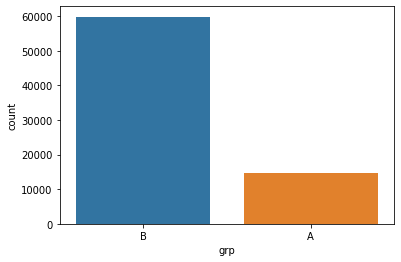

In [8]:
sns.countplot(data = groups_df, x = 'grp')

In [9]:
# дополнительный датасет с пользователями, который прислали спустя 2 дня после передачи данных
group_add_df.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [10]:
# размеры датасета
group_add_df.shape

(92, 2)

In [11]:
# наличие пропусков
group_add_df.isna().sum()

id     0
grp    0
dtype: int64

пропусков нет

In [12]:
# кол-во уникальных id соответствует срокам датасета -> дублей нет
group_add_df.nunique()

id     92
grp     2
dtype: int64

дублей нет

In [13]:
# размеры групп во втором сете данных
group_add_df.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

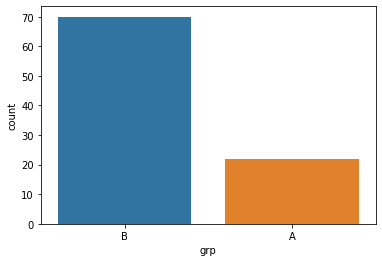

In [14]:
# размеры групп на диаграмме
sns.countplot(data = group_add_df, x = 'grp')

In [15]:
# датасет с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
active_studs_df.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [16]:
# количество активных пользователей из датасета
active_studs_df.shape

(8341, 1)

In [17]:
# все id уникальны, дублей нет
active_studs_df.nunique()

student_id    8341
dtype: int64

In [18]:
# датасет с информацией об оплатах пользователей в дни проведения эксперимента
checks_df.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [19]:
# размер датасета
checks_df.shape

(541, 2)

In [20]:
# из детальной информации о датасете с чеками видим, что разброс оплат составил от 199 до 4650
checks_df.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


In [21]:
checks_df.isna().sum()
# пустых значений нет

student_id    0
rev           0
dtype: int64

In [22]:
checks_df.nunique()
# все id уникальны, кол-во соответвует размеру датасета, дублей нет

student_id    541
rev            39
dtype: int64

In [23]:
# сразу сохраним общую сумму оплат для возможной будущей проверки
total_sum = checks_df.rev.sum()

In [24]:
# добавим к первоначальным данным дополнительные и сверим по количеству уникальных пользователей
df = groups_df.append(group_add_df)
df.id.nunique()

74576

In [25]:
groups_df.id.nunique() + group_add_df.id.nunique()

74576

**Цифры совпадают!** Значит во втором датасете присутствуют данные только о новых пользователях. В противном случае в объединенной таблице df уникальных пользователей было бы меньше. Идем дальше.

---
#### Итак, все готово для начала анализа. Но сначала определим цели!

### Какие метрики можно применить? Что именно должно улучшиться?
Новая механика оплаты услуг на сайте преследует ключевую цель:
**Увеличение дохода с продаж курсов**

**Важно!** Оценивать улучшения будем только по <u>активным пользователям</u> - тем, что зашли на платформу в дни эксперимента!

Для оценки улучшений я предлагаю использовать следующие *метрики*:

 - **увеличение дохода:**
* *ARPAU* - чтобы понимать, стали ли больше платить активные пользователи?
* *ARPAPU* - для отслеживания изменения среднего дохода с платящего активного пользователя.

!!! Отдельно отмечу, что мы не можем рассматривать метрику AOV (cредний чек), так как не располагаем данными о количестве покупок каждого пользователя.


 - **оптимизация воронки продаж:**
* *СR активного пользователя в покупателя* - стало ли больше покупателей среди активных пользователей?

**Указанные метрики рассчитаем для целевой (В) и контрольной (А) групп.**

### А какое минимальное улучшение мы сможем "поймать" A/B-тестом?
Для проведения корректного A/B-тестирования необходимо понять, для обнаружения какого минимального размера различий достаточна имеющаяся выборка? Вообще это делают на этапе сплитования, при определении размера групп, но мы убедимся, какого размера различия позволяют задетектировать наши группы.

Проведём оценку **минимального детектируемого эффекта (MDE)**  с применением функции библиотеки pingouin

In [26]:
# размер выборки берем из исходных данных по основному и дополнительному датасету
obs_size = df.id.nunique()
# вероятность ошибки I рода:отклонить нулевую гипотезу, хотя она верна (возьмем стандарт)
alpha = 0.05
# мощность (вероятность обнаружить различия, когда они реально есть (т.е. не совершить ошибку II рода)) 
# примем тоже стандартно
power = 0.8
# число степеней свободы dof принимаем равным 1 (считаем по таблице сопряженности)
print('Минимальный детектируемый эффект(MDE)\nдля теста Хи-квадрат: %.0f' %\
      (pg.power_chi2(dof=1, n=obs_size, power=0.80, alpha=alpha) * 100), '%')

Минимальный детектируемый эффект(MDE)
для теста Хи-квадрат: 1 %


In [27]:
print('для Т-теста: %.0f' %\
      (pg.power_ttest(n=obs_size, power=0.80, alpha=alpha, contrast='paired') * 100), '%')

для Т-теста: 1 %


Это значит, что при A/B-тесте могут быть обнаружены отклонения более 0,01. Для нас этого достаточно!

### Собираем данные для анализа

План действий:
- выберем из основного датасета с группами (df) только активных студентов с помощью объединения 'inner'
- "подтянем" к полученному датафрейму чеки
- значения NaN заменим на нули
- заменим тип данных на целые числа (int) для удобства восприятия

In [28]:
# переименуем столбцы для объединения
active_studs_df=active_studs_df.rename(columns={'student_id': 'id'})
checks_df=checks_df.rename(columns={'student_id': 'id'}).assign(paid=1)

In [29]:
# данные для анализа
data=df\
    .merge(active_studs_df, on='id', how='inner')\
    .merge(checks_df, on='id', how='left')\
    .fillna(0) \
    .astype({'rev': int, 'paid': int})
data.head()

,id,grp,rev,paid
0,1627,A,990,1
1,2085,B,0,0
2,2215,B,0,0
3,3391,A,0,0
4,3401,B,0,0


## Рассчитываем метрики по группам

In [30]:
metr_df=data \
    .groupby('grp', as_index=False).agg({'id': 'count', 'paid': 'sum', 'rev': 'sum'})\
    .assign(CR=lambda x:round (x.paid/x.id * 100, 2))\
    .assign(ARPAU=lambda x:round (x.rev/x.id, 2))\
    .assign(ARPAPU=lambda x:round (x.rev/x.paid, 2))
metr_df

,grp,id,paid,rev,CR,ARPAU,ARPAPU
0,A,1538,78,72820,5.07,47.35,933.59
1,B,6803,314,394974,4.62,58.06,1257.88


Проверим, всю ли выручку принесли активные пользователи в дни эксперимента

In [31]:
if metr_df.rev.sum() == total_sum:
    print ('Всю выручку в дни эксперимента сделали активные пользователи')
else:
    print('Сумма выручки в дни эксперимента:', round(total_sum, 2))
    print('Выручка от активных пользователей:', metr_df.rev.sum().round(2))
    print('Неактивные пользователи как-то оплатили в дни эксперимента:', round(total_sum - metr_df.rev.sum(), 2))

Сумма выручки в дни эксперимента: 573326.0
Выручка от активных пользователей: 467794
Неактивные пользователи как-то оплатили в дни эксперимента: 105532.0


Возможно, есть способ оплаты без захода на платформу.

---
### Переходим к анализу метрик в группах

* **CR - конверсия активного пользователя в покупателя**

In [32]:
print ('Конверсия активного пользователя в покупателя изменилась на %.1f' %\
       ((metr_df.CR[1]/metr_df.CR[0] - 1) * 100),'%')

Конверсия активного пользователя в покупателя изменилась на -8.9 %


При новом механизме оплаты **конверсия активного пользователя в покупателя снижается**. 

Оценим тестом Хи-квадрат, является ли данное изменение статзначимым  
**Нулевая гипотеза (H0)** : CR пользователей НЕ МЕНЯЕТСЯ от нового механизма оплаты, в генеральной совокупности она одинаковая 
**Альтернативная гипотеза (H1)** : разница в CR  пользователей есть

In [33]:
# таблица сопряженности
obs = pd.crosstab(data.grp, data.paid)
"""
Состав групп:
0 - пользователь
1 - покупатель
"""
obs

paid,0,1
grp,,
A,1460,78
B,6489,314


In [34]:
# применим тест Хи-квадрат к таблице сопряженности
res = ss.chi2_contingency(obs)
res

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[1465.71897854,   72.28102146],
        [6483.28102146,  319.71897854]]))

In [35]:
print('p-value =', round(res[1],2))

p-value = 0.49


pvalue > 0.05.
Это означает, что мы можем отклонить основную гипотезу(H0), а именно: в генеральной совокупности различия в CR нет. Конверсия пользователя в покупателя стат значимо не изменяется.

* **ARPAU - средний доход с активного пользователя**

In [36]:
# ARPAU для тестовой и контрольной групп
metr_df.ARPAU

0    47.35
1    58.06
Name: ARPAU, dtype: float64

In [37]:
print ('Увеличение ARPAU в тестовой группе на %.1f' %\
       ((metr_df.ARPAU[1]/metr_df.ARPAU[0]-1) * 100),'%')

Увеличение ARPAU в тестовой группе на 22.6 %


То есть, в целом активные пользователи в системе с новым механизмом оплаты стали тратить больше! 
#### Оценим эту разницу с помощью A/B-теста

Перед проведением А/В-тестов с дискретными величинами (выручка) сформулируем нулевую (H0) и альтернативную гипотезы (H1):  
**H0:** между ARPU в генеральной совокупности нет различий в средней выручке  
**H1:** между ARPU в группах есть стат. значимые различия в средней выручке

In [38]:
# выделим группы для последующего теста
test=data.query("grp == 'A'").rev
control=data.query("grp == 'B'").rev

# размеры групп
# количество пользователей в тестовой и контрольной группах
metr_df.id

0    1538
1    6803
Name: id, dtype: int64

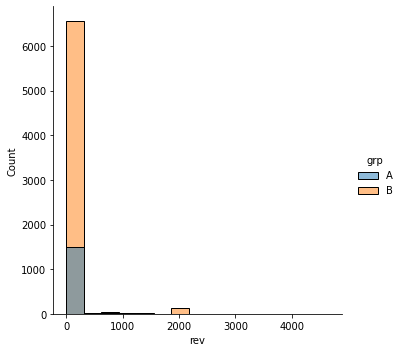

In [39]:
# распределение сумм чеков в группах на гистограмме
sns.displot(data=data, x='rev', hue='grp')

Распределение также не является нормальным, однако количество наблюдений значительное (> 1000 в каждой группе) - попробуем оценить значимость различия средней выручки с помощью Т-теста

In [40]:
ss.ttest_ind(test, control)

Ttest_indResult(statistic=-1.2253410584082978, pvalue=0.22048135171233407)

**Вывод:** Т-тест показывает уровень значимости p-value = 0.22, и **оснований отклонить нулевую гипотезу у нас нет**. То есть средняя выручка на активного пользователя не различается в генеральной совокупности. Но здесь может оказать влияние ненормальность распределения. Проверим еще одну метрику.

* **ARPAPU - средний доход с платящего активного пользователя**

In [41]:
# значения метрик в контрольной и тестовой группах
metr_df.ARPAPU

0     933.59
1    1257.88
Name: ARPAPU, dtype: float64

In [42]:
print ('Увеличение ARPAPU в тестовой группе на %.1f' %\
       ((metr_df.ARPAPU[1]/metr_df.ARPAPU[0]-1) * 100),'%')

Увеличение ARPAPU в тестовой группе на 34.7 %


Это означает, что активные пользователи, совершающие оплату, стали приносить больше выручки!

In [43]:
# выделим группы для последующего теста
test=data.query("paid == 1 and grp == 'A'").rev
control=data.query("paid == 1 and grp == 'B'").rev

In [44]:
# размеры групп
# количество пользователей, совершивших оплату, в тестовой и контрольной группах
metr_df.paid

0     78
1    314
Name: paid, dtype: int64

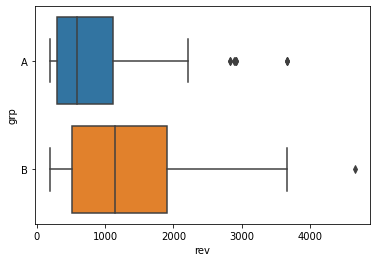

In [45]:
# выборки сумм чеков тестовой и контрольной группы на боксплоте
sns.boxplot(data=data.query('paid == 1'), x='rev', y='grp')

Как мы видим, в тестовой и контрольной группе есть выбросы (черные точки справа)

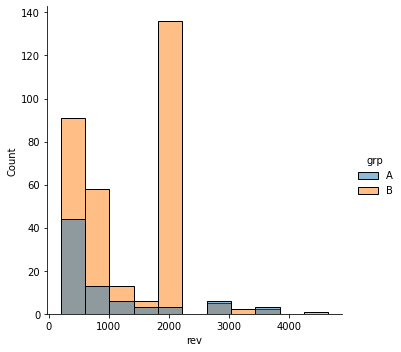

In [46]:
# распределение сумм чеков в группах на гистограмме
sns.displot(data=data.query('paid == 1'), x='rev', hue='grp')

Судя по гистограмме, оба распределения не являются нормальными. Проверим это утверждение тестами.

In [47]:
# тест на нормальность распределения размера выручки целевой группы
ss.normaltest(test)

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)

Значение pvalue < 0.05, значит мы **отклоняем нулевую гипотезу, что распределение нормальное**

На малых выборках нормальность распределения можно также проверить тестом Шапиро-Уилка

In [48]:
# Тест Шапиро-Уилка на нормальность
ss.shapiro(test)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

Значение pvalue < 0.05, то есть распределение сумм чеков в тестовой группе **значимо отличается от нормального!**

Аналогично проверим на нормальность распределения значений в контрольной группе

In [49]:
ss.normaltest(control)

NormaltestResult(statistic=6.79566391927267, pvalue=0.03344570304722356)

In [50]:
ss.shapiro(control)

ShapiroResult(statistic=0.854723334312439, pvalue=1.5436537542021223e-16)

значение pvalue < 0.05 в обоих тестах. **Распределение сумм чеков в контрольной группе не является нормальным**

Для оценки статзначимости различий средних доходов с активного платящего пользователя в группах применить Т-тест уже не получится, так как размер выборки мал и распределения не являются нормальным.  
Поэтому проведем A/B-тест с помощью метода **Bootstrap!**

In [51]:
# тестовая группа 
# оценка доверительного интервала среднего значения
ss.bootstrap((test, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=753.4341397321149, high=1164.8048898111992), standard_error=103.24195920213404)

In [52]:
# контрольная группа
# оценка доверительного интервала среднего значения
ss.bootstrap((control, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1171.822180239366, high=1347.2115919855448), standard_error=44.61845608467106)

**Вывод:** Так как доверительные интервалы средних сумм чеков (значения low-high) не пересекаются, то **различие ARPAPU в группах можно считать статзначимым**. Принимаем альтернативную гипотезу (H1).

### Итак, подведем итоги эксперимента
    1. Для понимания улучшений были выбраны три метрики поведения активных пользователей.
    
    2. Анализ конверсии пользователей в покупателя (CR) показал снижение на 8.9% в тествой группе. Меньше пользователей стали совершать покупку по сравнению с контрольной группой. Это плохо, но тест Хи-квадрат показывает, что данное изменение не является стат значимым, что позволяет сделать вывод об отсуствии влияния нового механизма на конверсию в покупателя.
    
    3. А вот средняя выручка с пользователя (ARPAU) в тестовой группе в дни эксперимента растет на 22.6%. Однако A/B-тест не позволяет нам с уверенностью принять это увеличение.
    
    4. Лучше обстоит дело с метрикой ARPAPU - средним доходом на платящего активного пользователя, результат A/B-теста дает все основания считать, что есть стат значимое различие между средней выручкой в группах (увеличение на 34.7% в тестовой группе).  

### ВЫВОД:  Таким образом, новый механизм оплаты стат значимо увеличивает в целевой группе средний доход на платящего активного пользователя на 34.7%.   
### <u>Можно рекомендовать к запуску на всех пользователей</u>

### Задание 2: SQL

#### 2.1 Очень усердные ученики
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [53]:
# задаем параметры подключения
connection={'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Изначально нам неизвестно, за какой период представлены данные, сделаем предвариетльный запрос, чтобы это выяснить

In [54]:
query="""
SELECT COUNT (DISTINCT toStartOfMonth(timest)) AS NumMonth FROM peas
"""
num_month=ph.read_clickhouse(query, connection=connection)
num_month

,NumMonth
0,1


Выяснили. Так как данные представлены за один месяц, то группировка результатов количества усердных учеников по месяцам нам не понадобится. Следовательно, SQL-запрос будет выглядеть следующим образом:

In [55]:
# делаем запрос
query="""
SELECT
    COUNT(st_id) AS NumGoodStud
FROM 
    (
    SELECT
            st_id,
            SUM(correct) AS NumPeas
    FROM peas
    GROUP BY 
            st_id
    HAVING
            NumPeas > 20
    )
"""
good_stud=ph.read_clickhouse(query, connection=connection)
good_stud

,NumGoodStud
0,130


**Вывод:** количество усердных студентов за текущий месяц, кто правильно решил хотя бы 20 "горошин", равняется 130 

#### 2.1 Оптимизация воронки
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
    
    * ARPU 
    * ARPAU 
    * CR в покупку 
    * СR активного пользователя в покупку 
    * CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [56]:
query="""
SELECT
    A.test_grp AS Test_group,
    -- Справочно можно добавить в таблицу исходные данные для расчета
    --SUM (B.Revenue) AS Revenue,
    --COUNT (A.st_id) AS NumStud,
    --SUM (C.ActiveStud) AS NumActive,
    --SUM (B.Buyer) AS NumBuy,
    --SUM (D.MathActive) AS NumMathActive,
    --SUM (F.BuyMath) AS NumBuyMath,
    ROUND (SUM (B.Revenue)/COUNT (A.st_id), 1) AS ARPU,
    ROUND (SUM (B.Revenue)/SUM (C.ActiveStud), 1) AS ARPAU,
    ROUND (SUM (B.Buyer)/COUNT (A.st_id)*100, 1) AS CR,
    ROUND (SUM (B.Buyer)/SUM (C.ActiveStud)*100, 1) AS CR_active,
    ROUND (SUM (F.BuyMath)/SUM (D.MathActive)*100, 1) AS CR_Math_active
FROM
    (
        SELECT -- к таблице с группами подтягиваем данные для расчета метрик
            *
        FROM studs AS A
        
        LEFT JOIN -- таблица учеников, кто сделал покупку (1 - купил)
            (
            SELECT 
                st_id,
                SUM(money) AS Revenue,
                1 AS Buyer
            FROM final_project_check
            GROUP BY st_id
            )
            AS B
        ON A.st_id = B.st_id
    
        LEFT JOIN -- таблица с усердными учениками (1 - усердный)
            ( 
            SELECT 
                st_id,
                1 AS ActiveStud
            FROM peas
            GROUP BY st_id
            HAVING SUM(correct) > 10
            ) AS C
        ON A.st_id = C.st_id
    
        LEFT JOIN -- таблица с активными студентами по математике (1 - активный)
            ( 
            SELECT 
                st_id,
                1 AS MathActive
            FROM peas
            WHERE subject = 'Math'
            GROUP BY st_id
            HAVING SUM(correct) >= 2
            ) AS D
        ON A.st_id = D.st_id
        
        LEFT JOIN -- таблица со студентами, купивших курс математики (1 - купил)
            (
            SELECT
                st_id,
                1 AS BuyMath
            FROM final_project_check
            WHERE subject = 'Math'
            ) AS F
        ON A.st_id = F.st_id
    )
    
GROUP BY
    A.test_grp
"""
funnel=ph.read_clickhouse(query, connection=connection)
funnel

,Test_group,ARPU,ARPAU,CR,CR_active,CR_Math_active
0,control,4541.0,10905.5,4.9,11.8,16.3
1,pilot,11508.5,35364.6,10.8,33.3,38.1


### Задание 3: Python

   1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
    
   2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [57]:
# сначала определяем функицю для построения диаграмм, в дальнейшем будем подавать ей на вход функцию расчета метрик
def show(metrics):
    """
    Функция построения диаграмм по нескольким метрикам.
    По оси х - группы для анализа,
    По оси у - величина метрики.
    
    Параметры
    ~~~~~~~~~
    metrics: Dataframe Pandas 
    
    Результат выполнения функции
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Столбчатые диаграммы по каждой из шести анализируемых метрик
    """
    sns.set(rc={'axes.titlesize': 18, 'axes.labelsize': 16, 'xtick.labelsize': 16, 
                'ytick.labelsize': 16,'axes.titlepad': 16, 
               })
    # задаем колонки датасета, по которым строим диаграммы и навзания диаграмм    
    cols_to_plot=['CR', 'ARPAU', 'ARPAPU']
    titles=['Конверсия активного пользователя\n в клиента (CR), %',
              'Средний доход на\n активного пользователя (ARPAU)',
              'Средний доход на\n активного клиента (ARPAPU)']

    # будем строить шесть графиков в одном поле    
    fig, axes=plt.subplots(ncols=3, nrows=1, figsize=(18, 6))
    fig.suptitle('Обзор метрик', fontsize=30)

    for ax, col, ttl in zip(axes.flatten(), cols_to_plot, titles):
        sns.barplot(data=metrics, x='grp', y=col, ax=ax)
        ax.set(xlabel='группы', ylabel='', title=ttl)
    
    #динамическая подстройка графика под размеры окна
    plt.tight_layout()
    
    plt.subplots_adjust(top=0.7, hspace=0.5, wspace=0.2)
    plt.show()

In [58]:
# определяем функцию для расчета метрик с учетом данных их дополнительного файла
def total_metrics(path_to_add=[]):
    """
    Функция расчета метрик с учетом данных из дополнительного файла
    
    Параметры:
    ~~~~~~~~~
    path_to_add - путь к csv-файлу с дополнительными данными
    Значение аргумента по умолчанию: path_to_add=[] - то есть, путь к дополнительному файлу не задан.
    
    Результат выполнения функции:
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    pandas DataFrame с метриками по группам студентов
    
    'grp': группа студентов для анализа
    'CR': конверсия активного пользователя в покупателя
    'ARPAU': средний доход на активного пользователя
    'ARPAPU': средний доход на активного клиента (платящего пользователя)
    
    Всего рассчитывается 3 метрики
    """
        
    # проверяем на наличие пути к доп файлу
    if path_to_add == []:
        add_df=[]
    else:
        # считываем доп данные по группам с переименованием имен заголовков 
        add_df=pd.read_csv(path + path_to_add, header=0, names=['id', 'grp'])
    
    # считываем данные по чекам, задаем метку покупателя (1)
    checks_df=pd.read_csv(path + 'checks.csv', sep=';', header=0, names=['id', 'rev']).assign(buyer=1)
    # считываем данные по активным студентам (зашли на платформу в дни эксперимента)
    active_df=pd.read_csv(path + 'active_studs.csv', header=0, names=['id'])
    
    # к основным данным по группам добавляем дополнительные, создаем доп колонки для расчета метрик 
    total_df=pd.read_csv(path + 'groups.csv', sep=';')\
        .append(add_df)\
        .merge(active_df, how='inner', on='id')\
        .merge(checks_df, how='left', on='id')\
        .fillna(0)\
        .astype({'rev': int, 'buyer': int}, errors='ignore')
    
    #формируем таблицу с метриками
    metrics_df=total_df\
        .groupby('grp', as_index=False)\
        .aggregate({'id': 'count', 
                   'rev': 'sum', 
                 'buyer': 'sum'})\
        .assign(CR=lambda x: (x.buyer/x.id * 100).round(2))\
        .assign(ARPAU=lambda x: (x.rev/x.id).round(2))\
        .assign(ARPAPU=lambda x: (x.rev/x.buyer).round(2))
        
    print('Результаты расчета метрик (файл доп данных:', path_to_add,\
          '):\n\n', metrics_df[['grp', 'CR', 'ARPAU', 'ARPAPU']])
    return show(metrics_df)

#### Проверяем работу обеих функций
   * без дополнительного файла с данными

Результаты расчета метрик (файл доп данных: [] ):

   grp    CR  ARPAU   ARPAPU
0   A  5.08  47.44   933.59
1   B  4.61  57.86  1255.83


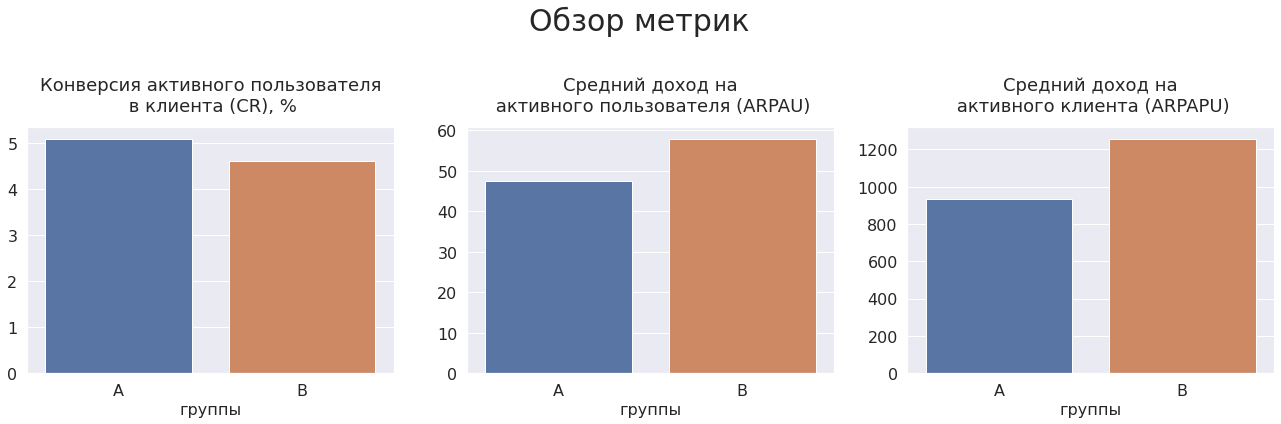

In [59]:
total_metrics()

   * с дополнительным файлом с данными

Результаты расчета метрик (файл доп данных: group_add.csv ):

   grp    CR  ARPAU   ARPAPU
0   A  5.07  47.35   933.59
1   B  4.62  58.06  1257.88


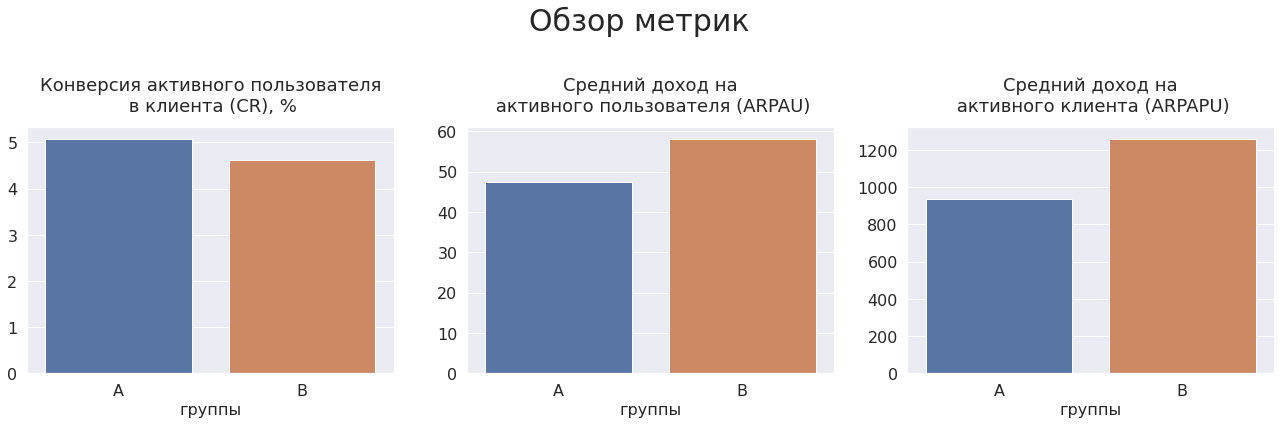

In [60]:
total_metrics('group_add.csv')

### Вывод: 
Таким образом, функция total_metrics() дает возможность пересчитывать метрики по группам студентов с учетом поступления дополнительных данных (либо без них). Далее, применяя функицю show() к полученным данным, имеем возможность визуально оценить различие метрик по группам А и В.